## 📊 COVID-19 Data Analysis (Matplotlib + Seaborn + SQL)

 # 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

# Style
sns.set_theme(style="whitegrid")


# 2. Load Dataset

In [2]:
df = pd.read_csv("covid_19.csv")

# Clean columns
df['Date'] = pd.to_datetime(df['Date'])
df['Province/State'].fillna("Unknown", inplace=True)

df.head()


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,Unknown,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,Unknown,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,Unknown,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,Unknown,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,Unknown,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


# 3. Basic Exploration

In [3]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  49068 non-null  object        
 1   Country/Region  49068 non-null  object        
 2   Lat             49068 non-null  float64       
 3   Long            49068 non-null  float64       
 4   Date            49068 non-null  datetime64[ns]
 5   Confirmed       49068 non-null  int64         
 6   Deaths          49068 non-null  int64         
 7   Recovered       49068 non-null  int64         
 8   Active          49068 non-null  int64         
 9   WHO Region      49068 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 3.7+ MB
None
                Lat          Long                 Date     Confirmed  \
count  49068.000000  49068.000000                49068  4.906800e+04   
mean      21.433730     23.528236  20

## 4. Exploratory Data Analysis (EDA)

# (a) Global Trend of Cases

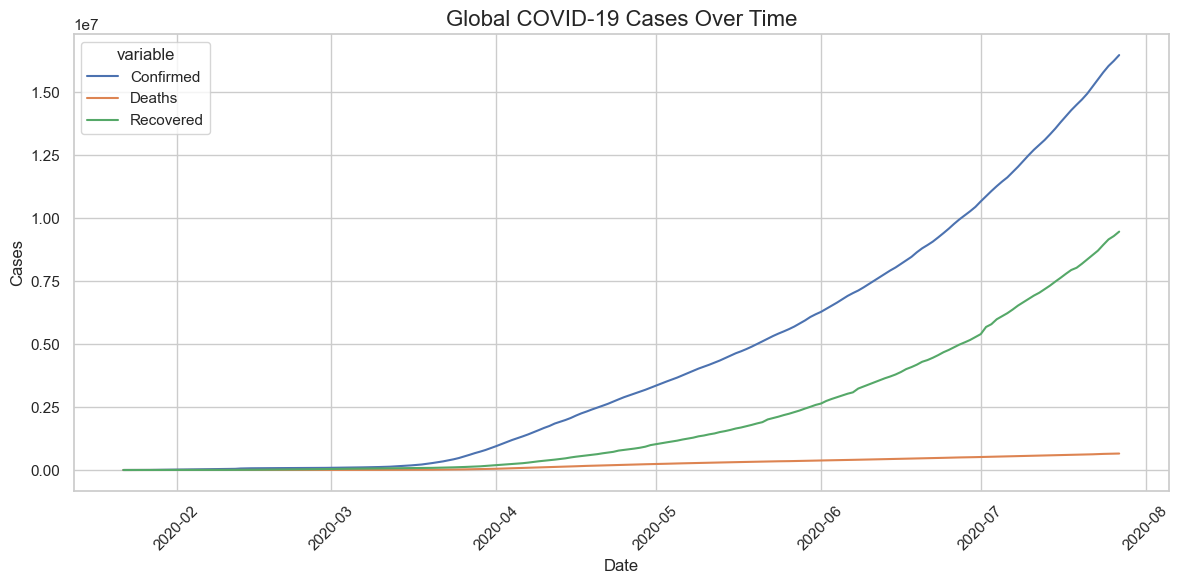

In [16]:
global_trend = df.groupby("Date")[["Confirmed","Deaths","Recovered"]].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(x="Date", y="value", hue="variable",
             data=pd.melt(global_trend, ["Date"]))
plt.title("Global COVID-19 Cases Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cases", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


# (b) Top 10 Countries by Confirmed Cases

C:\Users\DHARMESH\AppData\Local\Temp\ipykernel_15856\155632946.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Confirmed", y="Country/Region", data=top_countries, palette="Reds_r")


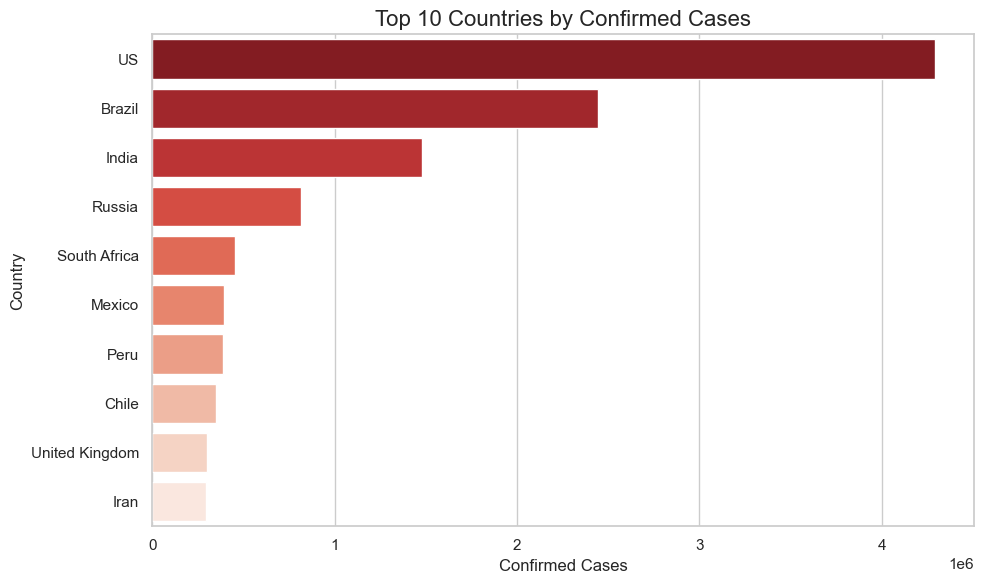

In [12]:
top_countries = df.groupby("Country/Region")["Confirmed"].max().sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x="Confirmed", y="Country/Region", data=top_countries, palette="Reds_r")
plt.title("Top 10 Countries by Confirmed Cases", fontsize=16)
plt.xlabel("Confirmed Cases", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.tight_layout()
plt.show()


# (c) Mortality Rate by Country

C:\Users\DHARMESH\AppData\Local\Temp\ipykernel_15856\2701314096.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MortalityRate", y="Country/Region", data=mortality, palette="coolwarm")


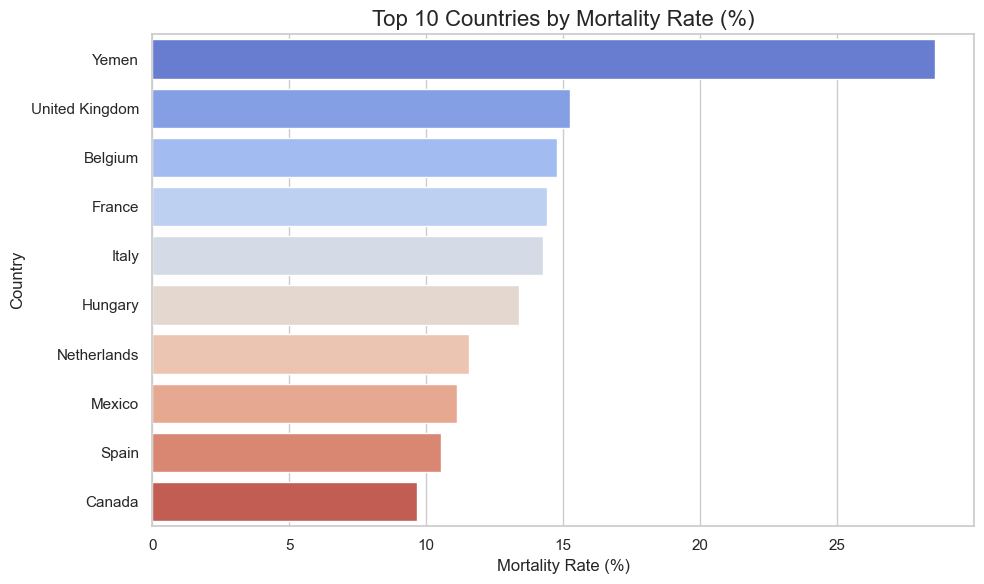

In [13]:
mortality = df.groupby("Country/Region")[["Confirmed","Deaths"]].max()
mortality = mortality[mortality["Confirmed"] > 1000]  # avoid small values
mortality["MortalityRate"] = (mortality["Deaths"] / mortality["Confirmed"]) * 100
mortality = mortality.sort_values("MortalityRate", ascending=False).head(10).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x="MortalityRate", y="Country/Region", data=mortality, palette="coolwarm")
plt.title("Top 10 Countries by Mortality Rate (%)", fontsize=16)
plt.xlabel("Mortality Rate (%)", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.tight_layout()
plt.show()


# (d) Cases Distribution by WHO Region

C:\Users\DHARMESH\AppData\Local\Temp\ipykernel_15856\2301774284.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Confirmed", y="WHO Region", data=region_cases, palette="Blues_d")


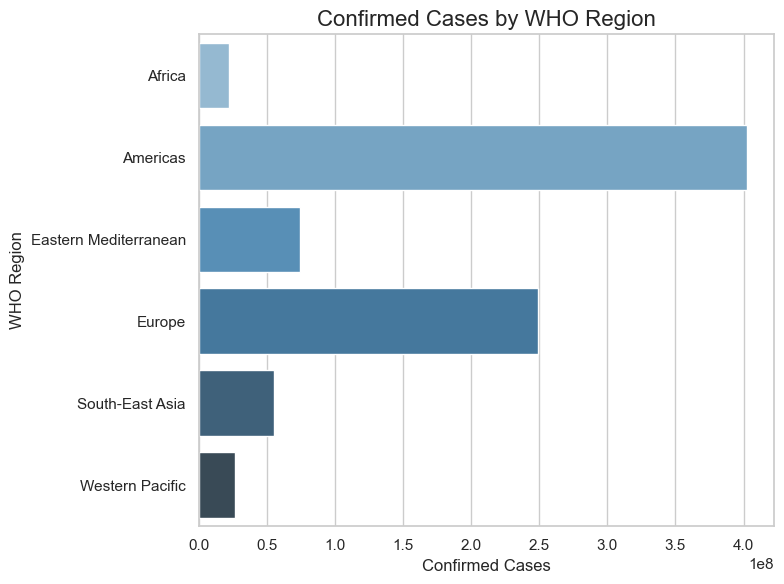

In [14]:
region_cases = df.groupby("WHO Region")[["Confirmed","Deaths","Recovered"]].sum().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x="Confirmed", y="WHO Region", data=region_cases, palette="Blues_d")
plt.title("Confirmed Cases by WHO Region", fontsize=16)
plt.xlabel("Confirmed Cases", fontsize=12)
plt.ylabel("WHO Region", fontsize=12)
plt.tight_layout()
plt.show()


# 5. SQL Queries on the Data

# (a) Setup SQLite

In [8]:
conn = sqlite3.connect(":memory:")
df.to_sql("covid", conn, index=False, if_exists="replace")


49068

# (b) Top 5 Countries by Confirmed Cases

In [9]:
query1 = """
SELECT "Country/Region", MAX(Confirmed) as MaxConfirmed
FROM covid
GROUP BY "Country/Region"
ORDER BY MaxConfirmed DESC
LIMIT 5;
"""
pd.read_sql(query1, conn)


,Country/Region,MaxConfirmed
0,US,4290259
1,Brazil,2442375
2,India,1480073
3,Russia,816680
4,South Africa,452529


# (c) Total Cases per WHO Region

In [10]:
query2 = """
SELECT "WHO Region", SUM(Confirmed) as TotalConfirmed, SUM(Deaths) as TotalDeaths
FROM covid
GROUP BY "WHO Region";
"""
pd.read_sql(query2, conn)


,WHO Region,TotalConfirmed,TotalDeaths
0,Africa,21791827,439978
1,Americas,402261194,19359292
2,Eastern Mediterranean,74082892,1924029
3,Europe,248879793,19271040
4,South-East Asia,55118365,1458134
5,Western Pacific,26374411,932430
